In [1]:
import torch
import sys

from helpers import *
from lrp_helpers import *
from lrp_database import *
from select_images_helpers import *

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

from pathlib import Path

# from yolo
from models.experimental import attempt_load

_ = torch.hub.load('ultralytics/yolov5', "yolov5s", pretrained=True)

Using cache found in /home/akanksha/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-11-14 Python-3.11.0rc1 torch-2.1.2+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81158MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
Using cache found in /home/akanksha/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-11-14 Python-3.11.0rc1 torch-2.1.2+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81158MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
Using cache found in /home/akanksha/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-11-14 Python-3.11.0rc1 torch-2.1.2+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81158MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


### load the model

In [2]:
#model_file = Path('../datasets/models/2021-10-follicle-detection-2-classes.zip')
# model_file = Path('all_classes_random_split.zip')
model_file = Path('animal_9_cls.zip')
device = torch.device('cpu')

weights = model_file
model = attempt_load(weights, device=device)

model_exp = attempt_load(weights, device=device)

model.eval();
model_exp.eval();


Fusing layers... 
Model summary: 440 layers, 141117904 parameters, 0 gradients
Fusing layers... 
Model summary: 440 layers, 141117904 parameters, 0 gradients


### parameters

In [3]:
# parameters
detect_thresh = 0.4
nms_thresh = 0.2
n_max = -1
if n_max<0:
    n_max = sys.maxsize

grad_of = "logit_class"
gamma = 0.05
input_lv, input_hv = (0, 1)

class_names = ['Gland','Growing_Follicle','Growing_no_nucleus','Other_Follicle','Primordial_Follicle_1','Primordial_Follicle_1_no_nuc','Primordial_Follicle_2','Primordial_Follicle_2_no_nuc','Vessel']

use_gpu_if_available = False

m_model = meta_model(model, 
                    detect_thresh = detect_thresh,
                    nms_thresh = nms_thresh,
                    )

m_model_exp = meta_model(model_exp,
                        detect_thresh = detect_thresh,
                        nms_thresh = nms_thresh,
                        )

#m_model.prepare_exp()

### create object table

#### True Positive

In [5]:
# image_path = r'/home/akanksha/interpretability-of-ML-models/lrp_4_yolov5/training_data_all_class/TP/images/validation'
# label_path = r'/home/akanksha/interpretability-of-ML-models/lrp_4_yolov5/training_data_all_class/TP/labels/validation'
# ds = CustomImageDataset(image_path, label_path)

#### False Negative

In [6]:
image_path = r'/home/akanksha/interpretability-of-ML-models/lrp_4_yolov5/training/images/validation'
label_path = r'/home/akanksha/interpretability-of-ML-models/lrp_4_yolov5/training/labels/validation'
ds = CustomImageDataset(image_path, label_path)

In [7]:
# imgs = []
# for i in os.listdir(image_path):
#     imgs.append(i)
# print(imgs)

#### False Positive

In [8]:
# image_path = r'/home/akanksha/interpretability-of-ML-models/lrp_4_yolov5/training_data_all_class/FP/images/validation'
# label_path = r'/home/akanksha/interpretability-of-ML-models/lrp_4_yolov5/training_data_all_class/FP/labels/validation'
# ds = CustomImageDataset(image_path, label_path)

In [10]:
blocks = []
for i in range(0,1):
    instance = ds.__getitem__(i)
    print(instance)
    print(len(instance['label']))
    blocks.append(create_result_table_image(m_model, instance))

result_table = pd.concat([pd.DataFrame(df) for df in blocks])
# result_table

{'image': <PIL.Image.Image image mode=RGB size=1280x1280 at 0x7904746D6110>, 'label': [[1.0, 0.132812, 0.0625, 0.235937, 0.125]], 'file_name': '04R024-319-1_03 - O2_x004_y003_f0.png'}
1


In [11]:
result_table

,img_name,object_id,real_class,object_class,confidence,center_true,center_pred,bb,real_bb
0,04R024-319-1_03 - O2_x004_y003_f0.png,object_0,1.0,1.0,0.688,"(0.132812, 0.0625)","(0.14797, 0.0698)",not impl.,not impl.
1,04R024-319-1_03 - O2_x004_y003_f0.png,object_1,NaN,2.0,0.285,NaN,NaN,NaN,not impl.


In [12]:
def extract_metrics_all(result_table, return_list = False):

    #t0
    df_t0_p0 = result_table[(result_table['real_class'] == 0) & (result_table['object_class'] == 0)].copy()
    df_t0_p1 = result_table[(result_table['real_class'] == 0) & (result_table['object_class'] == 1)].copy()
    df_t0_p2 = result_table[(result_table['real_class'] == 0) & (result_table['object_class'] == 2)].copy()
    df_t0_p3 = result_table[(result_table['real_class'] == 0) & (result_table['object_class'] == 3)].copy()
    df_t0_p4 = result_table[(result_table['real_class'] == 0) & (result_table['object_class'] == 4)].copy()
    df_t0_p5 = result_table[(result_table['real_class'] == 0) & (result_table['object_class'] == 5)].copy()
    df_t0_p6 = result_table[(result_table['real_class'] == 0) & (result_table['object_class'] == 6)].copy()
    df_t0_p7 = result_table[(result_table['real_class'] == 0) & (result_table['object_class'] == 7)].copy()
    df_t0_p8 = result_table[(result_table['real_class'] == 0) & (result_table['object_class'] == 8)].copy()

    # t1
    df_t1_p0 = result_table[(result_table['real_class'] == 1) & (result_table['object_class'] == 0)].copy()
    df_t1_p1 = result_table[(result_table['real_class'] == 1) & (result_table['object_class'] == 1)].copy()
    df_t1_p2 = result_table[(result_table['real_class'] == 1) & (result_table['object_class'] == 2)].copy()
    df_t1_p3 = result_table[(result_table['real_class'] == 1) & (result_table['object_class'] == 3)].copy()
    df_t1_p4 = result_table[(result_table['real_class'] == 1) & (result_table['object_class'] == 4)].copy()
    df_t1_p5 = result_table[(result_table['real_class'] == 1) & (result_table['object_class'] == 5)].copy()
    df_t1_p6 = result_table[(result_table['real_class'] == 1) & (result_table['object_class'] == 6)].copy()
    df_t1_p7 = result_table[(result_table['real_class'] == 1) & (result_table['object_class'] == 7)].copy()
    df_t1_p8 = result_table[(result_table['real_class'] == 1) & (result_table['object_class'] == 8)].copy()

    #t2
    df_t2_p0 = result_table[(result_table['real_class'] == 2) & (result_table['object_class'] == 0)].copy()
    df_t2_p1 = result_table[(result_table['real_class'] == 2) & (result_table['object_class'] == 1)].copy()
    df_t2_p2 = result_table[(result_table['real_class'] == 2) & (result_table['object_class'] == 2)].copy()
    df_t2_p3 = result_table[(result_table['real_class'] == 2) & (result_table['object_class'] == 3)].copy()
    df_t2_p4 = result_table[(result_table['real_class'] == 2) & (result_table['object_class'] == 4)].copy()
    df_t2_p5 = result_table[(result_table['real_class'] == 2) & (result_table['object_class'] == 5)].copy()
    df_t2_p6 = result_table[(result_table['real_class'] == 2) & (result_table['object_class'] == 6)].copy()
    df_t2_p7 = result_table[(result_table['real_class'] == 2) & (result_table['object_class'] == 7)].copy()
    df_t2_p8 = result_table[(result_table['real_class'] == 2) & (result_table['object_class'] == 8)].copy()

    #t3
    df_t3_p0 = result_table[(result_table['real_class'] == 3) & (result_table['object_class'] == 0)].copy()
    df_t3_p1 = result_table[(result_table['real_class'] == 3) & (result_table['object_class'] == 1)].copy()
    df_t3_p2 = result_table[(result_table['real_class'] == 3) & (result_table['object_class'] == 2)].copy()
    df_t3_p3 = result_table[(result_table['real_class'] == 3) & (result_table['object_class'] == 3)].copy()
    df_t3_p4 = result_table[(result_table['real_class'] == 3) & (result_table['object_class'] == 4)].copy()
    df_t3_p5 = result_table[(result_table['real_class'] == 3) & (result_table['object_class'] == 5)].copy()
    df_t3_p6 = result_table[(result_table['real_class'] == 3) & (result_table['object_class'] == 6)].copy()
    df_t3_p7 = result_table[(result_table['real_class'] == 3) & (result_table['object_class'] == 7)].copy()
    df_t3_p8 = result_table[(result_table['real_class'] == 3) & (result_table['object_class'] == 8)].copy()
    
    #t4
    df_t4_p0 = result_table[(result_table['real_class'] == 4) & (result_table['object_class'] == 0)].copy()
    df_t4_p1 = result_table[(result_table['real_class'] == 4) & (result_table['object_class'] == 1)].copy()
    df_t4_p2 = result_table[(result_table['real_class'] == 4) & (result_table['object_class'] == 2)].copy()
    df_t4_p3 = result_table[(result_table['real_class'] == 4) & (result_table['object_class'] == 3)].copy()
    df_t4_p4 = result_table[(result_table['real_class'] == 4) & (result_table['object_class'] == 4)].copy()
    df_t4_p5 = result_table[(result_table['real_class'] == 4) & (result_table['object_class'] == 5)].copy()
    df_t4_p6 = result_table[(result_table['real_class'] == 4) & (result_table['object_class'] == 6)].copy()
    df_t4_p7 = result_table[(result_table['real_class'] == 4) & (result_table['object_class'] == 7)].copy()
    df_t4_p8 = result_table[(result_table['real_class'] == 4) & (result_table['object_class'] == 8)].copy()

    #t5
    df_t5_p0 = result_table[(result_table['real_class'] == 5) & (result_table['object_class'] == 0)].copy()
    df_t5_p1 = result_table[(result_table['real_class'] == 5) & (result_table['object_class'] == 1)].copy()
    df_t5_p2 = result_table[(result_table['real_class'] == 5) & (result_table['object_class'] == 2)].copy()
    df_t5_p3 = result_table[(result_table['real_class'] == 5) & (result_table['object_class'] == 3)].copy()
    df_t5_p4 = result_table[(result_table['real_class'] == 5) & (result_table['object_class'] == 4)].copy()
    df_t5_p5 = result_table[(result_table['real_class'] == 5) & (result_table['object_class'] == 5)].copy()
    df_t5_p6 = result_table[(result_table['real_class'] == 5) & (result_table['object_class'] == 6)].copy()
    df_t5_p7 = result_table[(result_table['real_class'] == 5) & (result_table['object_class'] == 7)].copy()
    df_t5_p8 = result_table[(result_table['real_class'] == 5) & (result_table['object_class'] == 8)].copy()

    #t6
    df_t6_p0 = result_table[(result_table['real_class'] == 6) & (result_table['object_class'] == 0)].copy()
    df_t6_p1 = result_table[(result_table['real_class'] == 6) & (result_table['object_class'] == 1)].copy()
    df_t6_p2 = result_table[(result_table['real_class'] == 6) & (result_table['object_class'] == 2)].copy()
    df_t6_p3 = result_table[(result_table['real_class'] == 6) & (result_table['object_class'] == 3)].copy()
    df_t6_p4 = result_table[(result_table['real_class'] == 6) & (result_table['object_class'] == 4)].copy()
    df_t6_p5 = result_table[(result_table['real_class'] == 6) & (result_table['object_class'] == 5)].copy()
    df_t6_p6 = result_table[(result_table['real_class'] == 6) & (result_table['object_class'] == 6)].copy()
    df_t6_p7 = result_table[(result_table['real_class'] == 6) & (result_table['object_class'] == 7)].copy()
    df_t6_p8 = result_table[(result_table['real_class'] == 6) & (result_table['object_class'] == 8)].copy()

    #t7
    df_t7_p0 = result_table[(result_table['real_class'] == 7) & (result_table['object_class'] == 0)].copy()
    df_t7_p1 = result_table[(result_table['real_class'] == 7) & (result_table['object_class'] == 1)].copy()
    df_t7_p2 = result_table[(result_table['real_class'] == 7) & (result_table['object_class'] == 2)].copy()
    df_t7_p3 = result_table[(result_table['real_class'] == 7) & (result_table['object_class'] == 3)].copy()
    df_t7_p4 = result_table[(result_table['real_class'] == 7) & (result_table['object_class'] == 4)].copy()
    df_t7_p5 = result_table[(result_table['real_class'] == 7) & (result_table['object_class'] == 5)].copy()
    df_t7_p6 = result_table[(result_table['real_class'] == 7) & (result_table['object_class'] == 6)].copy()
    df_t7_p7 = result_table[(result_table['real_class'] == 7) & (result_table['object_class'] == 7)].copy()
    df_t7_p8 = result_table[(result_table['real_class'] == 7) & (result_table['object_class'] == 8)].copy()

    #t8
    df_t8_p0 = result_table[(result_table['real_class'] == 8) & (result_table['object_class'] == 0)].copy()
    df_t8_p1 = result_table[(result_table['real_class'] == 8) & (result_table['object_class'] == 1)].copy()
    df_t8_p2 = result_table[(result_table['real_class'] == 8) & (result_table['object_class'] == 2)].copy()
    df_t8_p3 = result_table[(result_table['real_class'] == 8) & (result_table['object_class'] == 3)].copy()
    df_t8_p4 = result_table[(result_table['real_class'] == 8) & (result_table['object_class'] == 4)].copy()
    df_t8_p5 = result_table[(result_table['real_class'] == 8) & (result_table['object_class'] == 5)].copy()
    df_t8_p6 = result_table[(result_table['real_class'] == 8) & (result_table['object_class'] == 6)].copy()
    df_t8_p7 = result_table[(result_table['real_class'] == 8) & (result_table['object_class'] == 7)].copy()
    df_t8_p8 = result_table[(result_table['real_class'] == 8) & (result_table['object_class'] == 8)].copy()
    
    # pbn
    df_t0_bn = result_table[(result_table['real_class'] == 0) & (result_table['object_class'].isna())].copy()
    df_t1_bn = result_table[(result_table['real_class'] == 1) & (result_table['object_class'].isna())].copy()
    df_t2_bn = result_table[(result_table['real_class'] == 2) & (result_table['object_class'].isna())].copy()
    df_t3_bn = result_table[(result_table['real_class'] == 3) & (result_table['object_class'].isna())].copy()
    df_t4_bn = result_table[(result_table['real_class'] == 4) & (result_table['object_class'].isna())].copy()
    df_t5_bn = result_table[(result_table['real_class'] == 5) & (result_table['object_class'].isna())].copy()
    df_t6_bn = result_table[(result_table['real_class'] == 6) & (result_table['object_class'].isna())].copy()
    df_t7_bn = result_table[(result_table['real_class'] == 7) & (result_table['object_class'].isna())].copy()
    df_t8_bn = result_table[(result_table['real_class'] == 8) & (result_table['object_class'].isna())].copy()
    
    

    confusion_matrix = pd.DataFrame({'p_0':[df_t0_p0.shape[0],df_t1_p0.shape[0],df_t2_p0.shape[0],df_t3_p0.shape[0],df_t4_p0.shape[0],df_t5_p0.shape[0],df_t6_p0.shape[0],df_t7_p0.shape[0],df_t8_p0.shape[0]],
                                     'p_1':[df_t0_p1.shape[0],df_t1_p1.shape[0],df_t2_p1.shape[0],df_t3_p1.shape[0],df_t4_p1.shape[0],df_t5_p1.shape[0],df_t6_p1.shape[0],df_t7_p1.shape[0],df_t8_p1.shape[0]],
                                     'p_2':[df_t0_p2.shape[0],df_t1_p2.shape[0],df_t2_p2.shape[0],df_t3_p2.shape[0],df_t4_p2.shape[0],df_t5_p2.shape[0],df_t6_p2.shape[0],df_t7_p2.shape[0],df_t8_p2.shape[0]],
                                     'p_3':[df_t0_p3.shape[0],df_t1_p3.shape[0],df_t2_p3.shape[0],df_t3_p3.shape[0],df_t4_p3.shape[0],df_t5_p3.shape[0],df_t6_p3.shape[0],df_t7_p3.shape[0],df_t8_p3.shape[0]],
                                     'p_4':[df_t0_p4.shape[0],df_t1_p4.shape[0],df_t2_p4.shape[0],df_t3_p4.shape[0],df_t4_p4.shape[0],df_t5_p4.shape[0],df_t6_p4.shape[0],df_t7_p4.shape[0],df_t8_p4.shape[0]],
                                     'p_5':[df_t0_p5.shape[0],df_t1_p5.shape[0],df_t2_p5.shape[0],df_t3_p5.shape[0],df_t4_p5.shape[0],df_t5_p5.shape[0],df_t6_p5.shape[0],df_t7_p5.shape[0],df_t8_p5.shape[0]],
                                     'p_6':[df_t0_p6.shape[0],df_t1_p6.shape[0],df_t2_p6.shape[0],df_t3_p6.shape[0],df_t4_p6.shape[0],df_t5_p6.shape[0],df_t6_p6.shape[0],df_t7_p6.shape[0],df_t8_p6.shape[0]],
                                     'p_7':[df_t0_p7.shape[0],df_t1_p7.shape[0],df_t2_p7.shape[0],df_t3_p7.shape[0],df_t4_p7.shape[0],df_t5_p7.shape[0],df_t6_p7.shape[0],df_t7_p7.shape[0],df_t8_p7.shape[0]],
                                     'p_8':[df_t0_p8.shape[0],df_t1_p8.shape[0],df_t2_p8.shape[0],df_t3_p8.shape[0],df_t4_p8.shape[0],df_t5_p8.shape[0],df_t6_p8.shape[0],df_t7_p8.shape[0],df_t8_p8.shape[0]],
                                     'bn' :[df_t0_bn.shape[0],df_t1_bn.shape[0],df_t2_bn.shape[0],df_t3_bn.shape[0],df_t4_bn.shape[0],df_t5_bn.shape[0],df_t6_bn.shape[0],df_t7_bn.shape[0],df_t8_bn.shape[0]],
                                     },index=['t0','t1','t2','t3','t4','t5','t6','t7','t8'])

    # if return_list == 'tnpn':
    #     return confusion_matrix, df_t0_p0, df_t1_p1, df_t2_p2, df_t3_p3, df_t4_p4, df_t5_p5, df_t6_p6, df_t7_p7, df_t8_p8
    if return_list == 't0pn':
        return confusion_matrix, df_t0_p0, df_t0_p1, df_t0_p2, df_t0_p3, df_t0_p4, df_t0_p5, df_t0_p6, df_t0_p7, df_t0_p8
    elif return_list == 't1pn':
        return confusion_matrix, df_t1_p0, df_t1_p1, df_t1_p2, df_t1_p3, df_t1_p4, df_t1_p5, df_t1_p6, df_t1_p7, df_t1_p8
    elif return_list == 't2pn':
        return confusion_matrix, df_t2_p0, df_t2_p1, df_t2_p2, df_t2_p3, df_t2_p4, df_t2_p5, df_t2_p6, df_t2_p7, df_t2_p8
    elif return_list == 't3pn':
        return confusion_matrix, df_t3_p0, df_t3_p1, df_t3_p2, df_t3_p3, df_t3_p4, df_t3_p5, df_t3_p6, df_t3_p7, df_t3_p8
    elif return_list == 't4pn':
        return confusion_matrix, df_t4_p0, df_t4_p1, df_t4_p2, df_t4_p3, df_t4_p4, df_t4_p5, df_t4_p6, df_t4_p7, df_t4_p8
    elif return_list == 't5pn':
        return confusion_matrix, df_t5_p0, df_t5_p1, df_t5_p2, df_t5_p3, df_t5_p4, df_t5_p5, df_t5_p6, df_t5_p7, df_t5_p8
    elif return_list == 't6pn':
        return confusion_matrix, df_t6_p0, df_t6_p1, df_t6_p2, df_t6_p3, df_t6_p4, df_t6_p5, df_t6_p6, df_t6_p7, df_t6_p8
    elif return_list == 't7pn':
        return confusion_matrix, df_t7_p0, df_t7_p1, df_t7_p2, df_t7_p3, df_t7_p4, df_t7_p5, df_t7_p6, df_t7_p7, df_t7_p8
    elif return_list == 't8pn':
        return confusion_matrix, df_t8_p0, df_t8_p1, df_t8_p2, df_t8_p3, df_t8_p4, df_t8_p5, df_t8_p6, df_t8_p7, df_t8_p8
    elif return_list == 'tnbn':
        return confusion_matrix, df_t0_bn, df_t1_bn, df_t2_bn, df_t3_bn, df_t4_bn, df_t5_bn, df_t6_bn, df_t7_bn, df_t8_bn
    else:
        return confusion_matrix, df_t0_p0, df_t1_p1, df_t2_p2, df_t3_p3, df_t4_p4, df_t5_p5, df_t6_p6, df_t7_p7, df_t8_p8
    
# explain top x of c_matrix
def explain_from_cmatrix(result_table, cm_type, x=False):
    _, df_x = extract_metrics(result_table, cm_type)
    if cm_type:
        if x:
            df_x.sort_values(by='confidence',inplace=True)
            return df_x['img_name'].unique().tolist()[:x]
        else:
            df_x.sort_values(by='confidence',inplace=True)
            return df_x['img_name'].unique().tolist()
        
def get_cm(result_table):
    cm, _ = extract_metrics(result_table)
    return cm

In [13]:
# explain top x of c_matrix
def explain_from_cmatrix(result_table, cm_type, x=False):
    cm, df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8 = extract_metrics_all(result_table, cm_type)
    if cm_type:
        if x:
            df_x.sort_values(by='confidence',inplace=True)
            return df_x['img_name'].unique().tolist()[:x]
        else:
            # df_0.sort_values(by='confidence',inplace=True)
            list = [df_0['img_name'],df_1['img_name'],df_2['img_name'],df_3['img_name'],df_4['img_name'],df_5['img_name'],df_6['img_name'],df_7['img_name'],df_8['img_name']]
            return pd.concat(list).unique().tolist()

explain_from_cmatrix(result_table,'t0pn')

imgs = explain_from_cmatrix(result_table,'t0pn')+explain_from_cmatrix(result_table,'t1pn')+explain_from_cmatrix(result_table,'t2pn')+explain_from_cmatrix(result_table,'t3pn')+explain_from_cmatrix(result_table,'t4pn')+explain_from_cmatrix(result_table,'t5pn')+explain_from_cmatrix(result_table,'t6pn')+explain_from_cmatrix(result_table,'t7pn')+explain_from_cmatrix(result_table,'t8pn')+explain_from_cmatrix(result_table,'tnbn')
imgs = set(imgs)
imgs

{'04R024-319-1_03 - O2_x004_y003_f0.png'}

In [16]:
# explain top x of c_matrix
def explain_from_cmatrix(result_table, cm_type, x=False):
    cm, df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8 = extract_metrics_all(result_table, cm_type)
    print("cm", cm)
    if cm_type:
        if x:
            df_x.sort_values(by='confidence',inplace=True)
            return df_x['img_name'].unique().tolist()[:x]
        else:
            # df_0.sort_values(by='confidence',inplace=True)
            list = [df_0['img_name'],df_1['img_name'],df_2['img_name'],df_3['img_name'],df_4['img_name'],df_5['img_name'],df_6['img_name'],df_7['img_name'],df_8['img_name']]
            return pd.concat(list).unique().tolist()
            
explain_from_cmatrix(result_table,'t1pn')

cm     p_0  p_1  p_2  p_3  p_4  p_5  p_6  p_7  p_8  bn
t0    0    0    0    0    0    0    0    0    0   0
t1    0    1    0    0    0    0    0    0    0   0
t2    0    0    0    0    0    0    0    0    0   0
t3    0    0    0    0    0    0    0    0    0   0
t4    0    0    0    0    0    0    0    0    0   0
t5    0    0    0    0    0    0    0    0    0   0
t6    0    0    0    0    0    0    0    0    0   0
t7    0    0    0    0    0    0    0    0    0   0
t8    0    0    0    0    0    0    0    0    0   0


['04R024-319-1_03 - O2_x004_y003_f0.png']

<class 'models.common.Conv'>: 167
<class 'torch.nn.modules.conv.Conv2d'>: 1
<class 'models.common.Bottleneck'>: 60
We have 60 Bottlenecks
and 32 of them with add=True
cm     p_0  p_1  p_2  p_3  p_4  p_5  p_6  p_7  p_8  bn
t0    0    0    0    0    0    0    0    0    0   0
t1    0    1    0    0    0    0    0    0    0   0
t2    0    0    0    0    0    0    0    0    0   0
t3    0    0    0    0    0    0    0    0    0   0
t4    0    0    0    0    0    0    0    0    0   0
t5    0    0    0    0    0    0    0    0    0   0
t6    0    0    0    0    0    0    0    0    0   0
t7    0    0    0    0    0    0    0    0    0   0
t8    0    0    0    0    0    0    0    0    0   0
img_id 0
img 04R024-319-1_03 - O2_x004_y003_f0.png
class_names ['Gland', 'Growing_Follicle', 'Growing_no_nucleus', 'Other_Follicle', 'Primordial_Follicle_1', 'Primordial_Follicle_1_no_nuc', 'Primordial_Follicle_2', 'Primordial_Follicle_2_no_nuc', 'Vessel']
model preds tensor([[4.24571e+01, 0.00000e+00, 3.3634

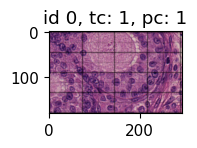

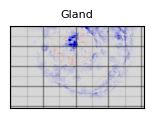

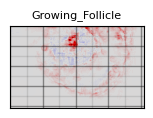

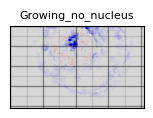

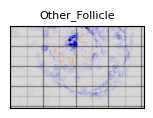

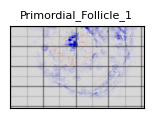

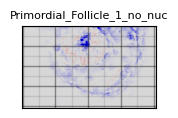

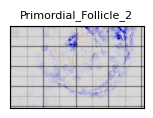

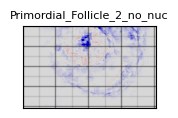

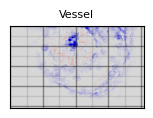

object_index 2


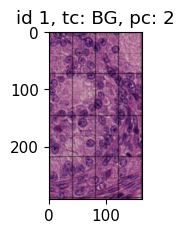

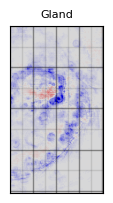

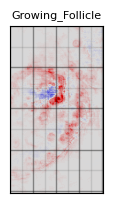

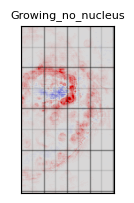

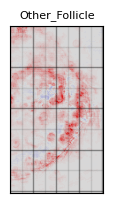

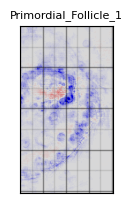

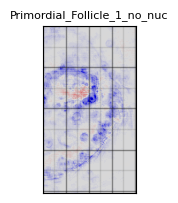

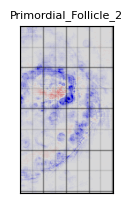

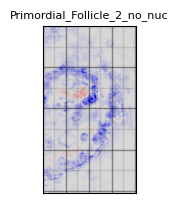

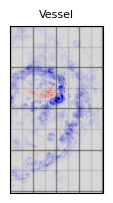

,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_5,heatmap_6,heatmap_7,heatmap_8,classes
0,1,1,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,2,BG,FP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


In [17]:
focus_conv, arr_yolo_convs, arr_inside_yolo_convs, arr_detection_convs, arr_summation_shortcuts = prepare_for_lrp(m_model)
#m_model.prepare_exp()

#m_model_exp.prepare_exp() # not reversible yet
for img_id, img in enumerate(explain_from_cmatrix(result_table,'t1pn')):
    instance = ds.__getitem__(ds.__getid__(img))
    image_raw = instance['image']
    model_prediction = m_model.predict(instance)
    # model preparation
    
    print("img_id",ds.__getid__(img))
    print("img",img)
    print("class_names", class_names)
    exp = explainer(model= m_model,
                    instance= instance,
                    detect_thresh= detect_thresh,
                    nms_thresh= nms_thresh,
                    grad_of=grad_of,
                    gamma=gamma,
                    n_max= n_max,
                    input_lv= input_lv,
                    input_hv= input_hv,
                    focus_conv= focus_conv,
                    arr_yolo_convs= arr_yolo_convs,
                    arr_inside_yolo_convs= arr_inside_yolo_convs,
                    arr_detection_convs= arr_detection_convs,
                    arr_summation_shortcuts= arr_summation_shortcuts
                    )

    df = exp.get_heatmaps_for_instance(exp, instance=instance, img=image_raw, class_names=class_names)

## Insert into Database

### Insert Model

In [16]:
model_file_path = '/'.join(os.path.abspath(model_file).split('/')[3:])
print(model_file_path)
# insert model into database
process_model_to_database(platform_url=None, local_model_path=model_file_path)

interpretability-of-ML-models/lrp_4_yolov5/animal_split_all_classes.zip
Model file exist.


### Insert Explanations

In [17]:
# #insert lrp explanations into table
xai_approach_metric = 'lrp'
Xai_Status = 'okay'
model_id_internal = insert_explanations(xai_approach_metric, Xai_Status, model_file_path)

Explanation exist for this model.


### Insert heatmap

In [18]:
focus_conv, arr_yolo_convs, arr_inside_yolo_convs, arr_detection_convs, arr_summation_shortcuts = prepare_for_lrp(m_model)
#m_model.prepare_exp()
#m_model_exp.prepare_exp() # not reversible yet
for img_id, img in enumerate(imgs):
    instance = ds.__getitem__(ds.__getid__(img))
    image_raw = instance['image']
    model_prediction = m_model.predict(instance)
    # model preparation
    
    print("img_id",ds.__getid__(img))
    print("img",img)
    exp = explainer(model= m_model,
                    instance= instance,
                    detect_thresh= detect_thresh,
                    nms_thresh= nms_thresh,
                    grad_of=grad_of,
                    gamma=gamma,
                    n_max= n_max,
                    input_lv= input_lv,
                    input_hv= input_hv,
                    focus_conv= focus_conv,
                    arr_yolo_convs= arr_yolo_convs,
                    arr_inside_yolo_convs= arr_inside_yolo_convs,
                    arr_detection_convs= arr_detection_convs,
                    arr_summation_shortcuts= arr_summation_shortcuts
                    )

    df = exp.get_heatmaps_for_instance(exp, instance=instance, img=image_raw, class_names=class_names)
    #insert heatmap into the database
    if df.empty:
        print("No image file for this class")
    else:
        for index, row in df.iterrows():
            binary_img = row['binary_img']
            original_class = row['org_cls']
            predicted_class = row['pred_cls']
            confidence = row['conf']
            objectiveness = row['obj']
            outcome = row['outcome']
            binary_heatmap_c0 = row['heatmap_0']
            binary_heatmap_c1 = row['heatmap_1']
            binary_heatmap_c2 = row['heatmap_2']
            binary_heatmap_c3 = row['heatmap_3']
            binary_heatmap_c4 = row['heatmap_4']
            binary_heatmap_c5 = row['heatmap_5']
            binary_heatmap_c6 = row['heatmap_6']
            binary_heatmap_c7 = row['heatmap_7']
            binary_heatmap_c8 = row['heatmap_8']
            classes = row['classes']
            
            insert_lrp(model_id_internal, binary_img, original_class, predicted_class, confidence, objectiveness, binary_heatmap_c0, binary_heatmap_c1, binary_heatmap_c2, binary_heatmap_c3, binary_heatmap_c4, binary_heatmap_c5, binary_heatmap_c6, binary_heatmap_c7, binary_heatmap_c8, classes, img, outcome)

<class 'models.common.Conv'>: 167
<class 'torch.nn.modules.conv.Conv2d'>: 1
<class 'models.common.Bottleneck'>: 60
We have 60 Bottlenecks
and 32 of them with add=True
img_id 5
img 04R024-389-1_03 - O1_x003_y001_f0.png
model preds tensor([[5.97477e+02, 7.20896e+02, 6.95550e+02, 8.13185e+02, 8.59190e-01, 6.00000e+00],
        [5.97261e+02, 8.98364e+02, 7.02444e+02, 9.96045e+02, 8.38682e-01, 6.00000e+00],
        [8.94856e+02, 7.95961e+02, 9.71393e+02, 8.70658e+02, 8.32027e-01, 4.00000e+00],
        [2.69968e+02, 2.29819e+02, 3.32755e+02, 3.00888e+02, 4.58127e-01, 4.00000e+00]])
n_p 4
labels: [[4.0, 0.728516, 0.65, 0.0554687, 0.05625], [6.0, 0.505859, 0.600391, 0.0726563, 0.0726563], [8.0, 0.641406, 0.669141, 0.06875, 0.0757812], [4.0, 0.1375, 0.664844, 0.04375, 0.0671875], [4.0, 0.235547, 0.207422, 0.0554687, 0.0601563], [6.0, 0.511328, 0.742578, 0.0851563, 0.0898438]]
n_l 6
FN
TP
TP
TP
TP
FN
labels box 0.235547 0.207422 0.0554687 0.0601563
labels box 266 227 337 304
FN
labels box 0.5113

,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,obj,heatmap_6,heatmap_7,heatmap_8,classes
0,6,4,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,0.91954,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,6,6,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,0.90936,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
2,4,8,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,0.87213,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
3,4,4,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,0.49269,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
4,4,4,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
5,6,6,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
img_id 15
img 04R024-389-1_12 - O1_x005_y006_f0.png
model preds tensor([[1.03315e+03, 4.26381e+02, 1.11117e+03, 4.97837e+02, 7.24455e-01, 4.00000e+00],
        [6.21406e+02, 3.24455e+02, 7.02129e+02, 4.09371e+02, 6.69932e-01, 6.00000e+00],
        [7.94578e+02, 4.64761e+02, 8.73472e+02, 5.43802e+02, 4.89810e-01, 4.00000e+00],
        [1.83599e+01, 1.72559e+02, 8.85887e+01, 2.43623e+02, 4.58717e-01, 4.00000e+00]])
n_p 4
labels: [[4.0, 0.0570312, 0.0523438, 0.0515625, 0.046875], [4.0, 0.0414062, 0.161328, 0.0625, 0.0460938], [4.0, 0.513281, 0.282813, 0.0640625, 0.0609375], [4.0, 0.833984, 0.359766, 0.0617188, 0.0492187], [4.0, 0.650391, 0.39375, 0.0507812, 0.0578125]]
n_l 5
FN
TP
TP
TP
TP
FN
labels box 0.650391 0.39375 0.0507812 0.0578125
l

,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_5,heatmap_6,heatmap_7,heatmap_8,classes
0,4,4,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,6,4,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
2,4,4,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
3,4,4,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
4,4,4,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
img_id 2
img 04R024-384-1_12 - O2_x004_y003_f0.png
model preds tensor([[8.46811e+02, 0.00000e+00, 9.34311e+02, 5.61315e+01, 5.56559e-01, 4.00000e+00]])
n_p 1
labels: [[8.0, 0.384766, 0.59375, 0.0460938, 0.05625], [6.0, 0.695312, 0.0179687, 0.05625, 0.0359375]]
n_l 2
FN
TP
FN
labels box 0.695312 0.0179687 0.05625 0.0359375
labels box 854 0 925 45


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_5,heatmap_6,heatmap_7,heatmap_8,classes
0,4,8,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,6,6,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
img_id 13
img 04R024-389-1_11 - O1_x002_y008_f0.png
model preds tensor([[267.23141, 430.25549, 338.42422, 502.44861,   0.55822,   8.00000]])
n_p 1
labels: [[8.0, 0.286719, 0.359766, 0.053125, 0.0507812], [8.0, 0.237891, 0.359375, 0.0617188, 0.059375], [8.0, 0.406641, 0.455859, 0.0773438, 0.0476562]]
n_l 3
FN
TP
FN
labels box 0.237891 0.359375 0.0617188 0.059375
labels box 265 422 344 498
FN
labels box 0.406641 0.455859 0.0773438 0.0476562
labels box 471 553 570 613


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_7,conf,obj,heatmap_8,classes
0,8,8,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.9578,0.58282,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
2,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
img_id 0
img 04R024-383-1_12 - O2_x006_y007_f0.png
model preds tensor([[6.53043e+02, 3.62052e+02, 7.37449e+02, 4.46001e+02, 5.80007e-01, 8.00000e+00]])
n_p 1
labels: [[8.0, 0.543359, 0.316016, 0.0570312, 0.0492187], [8.0, 0.604688, 0.204297, 0.034375, 0.0445313]]
n_l 2
FN
TP
FN
labels box 0.604688 0.204297 0.034375 0.0445313
labels box 752 233 796 290


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_7,conf,obj,heatmap_8,classes
0,8,8,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.96619,0.6003,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
img_id 6
img 04R024-389-1_03 - O2_x002_y003_f0.png
model preds tensor([[1.64526e+02, 5.46526e+02, 2.72899e+02, 6.52575e+02, 4.00136e-01, 8.00000e+00]])
n_p 1
labels: [[8.0, 0.177734, 0.469922, 0.0789062, 0.0710937], [8.0, 0.166797, 0.532031, 0.0835937, 0.065625]]
n_l 2
FN
TP
FN
labels box 0.166797 0.532031 0.0835937 0.065625
labels box 160 639 267 722


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_7,conf,obj,heatmap_8,classes
0,8,8,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.9823,0.40735,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
img_id 12
img 04R024-389-1_10 - O2_x004_y008_f0.png
model preds tensor([[5.03888e+02, 9.37698e+02, 5.72206e+02, 1.00784e+03, 6.91062e-01, 8.00000e+00]])
n_p 1
labels: [[8.0, 0.421875, 0.763281, 0.05625, 0.059375], [8.0, 0.693359, 0.441797, 0.0460938, 0.0476562]]
n_l 2
FN
TP
FN
labels box 0.693359 0.441797 0.0460938 0.0476562
labels box 858 535 916 596


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_7,conf,obj,heatmap_8,classes
0,8,8,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.97294,0.71028,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
img_id 11
img 04R024-389-1_10 - O1_x006_y006_f0.png
model preds tensor([[5.67633e+02, 8.30301e+02, 6.86662e+02, 9.39290e+02, 3.51106e-01, 8.00000e+00]])
n_p 1
labels: [[8.0, 0.553516, 0.529687, 0.0835937, 0.0578125], [8.0, 0.490234, 0.691797, 0.0820312, 0.0757812], [8.0, 0.757031, 0.642969, 0.159375, 0.107813]]
n_l 3
FN
TP
FN
labels box 0.490234 0.691797 0.0820312 0.0757812
labels box 575 837 679 934
FN
labels box 0.757031 0.642969 0.159375 0.107813
labels box 867 754 1070 892


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_7,conf,obj,heatmap_8,classes
0,8,8,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.9855,0.35627,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
2,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
img_id 18
img 04R024-390-1_03 - O1_x002_y007_f0.png
model preds tensor([[1.24359e+03, 8.62941e+02, 1.28004e+03, 9.50307e+02, 4.32538e-01, 4.00000e+00],
        [1.07196e+03, 1.11845e+03, 1.15303e+03, 1.19882e+03, 3.11115e-01, 6.00000e+00]])
n_p 2
labels: [[4.0, 0.985547, 0.705078, 0.0273438, 0.0664062], [1.0, 0.879297, 0.670703, 0.239844, 0.255469], [4.0, 0.869922, 0.903125, 0.0585938, 0.046875]]
n_l 3
FN
TP
TP
FN
labels box 0.869922 0.903125 0.0585938 0.046875
labels box 1076 1126 1151 1186


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_5,heatmap_6,heatmap_7,heatmap_8,classes
0,4,4,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,6,1,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
2,4,4,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
img_id 10
img 04R024-389-1_08 - O2_x003_y008_f0.png
model preds tensor([[1.18373e+02, 7.67518e+02, 2.13148e+02, 8.67402e+02, 6.26940e-01, 7.00000e+00],
        [6.95006e+01, 7.82782e+02, 1.41626e+02, 8.58062e+02, 5.14216e-01, 4.00000e+00],
        [5.74621e+02, 9.13359e+02, 6.53846e+02, 9.93793e+02, 3.93813e-01, 4.00000e+00],
        [5.74074e+02, 9.12603e+02, 6.54572e+02, 9.94633e+02, 3.07039e-01, 6.00000e+00]])
n_p 4
labels: [[8.0, 0.0800781, 0.638281, 0.0476562, 0.0515625], [7.0, 0.125, 0.632031, 0.065625, 0.071875], [4.0, 0.474609, 0.744141, 0.0617188, 0.0492187], [8.0, 0.852734, 0.346484, 0.0773438, 0.0492187], [8.0, 0.920703, 0.284375, 0.0382813, 0.04375]]
n_l 5
FN
TP
TP
TP
TP
FN
labels box 0.920703 0.284375 0.0382813 0.04375
labels box 1154 336 1202 392


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,conf,obj,heatmap_7,heatmap_8,classes
0,7,8,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,0.78113,0.80261,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,4,7,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,0.63257,0.8129,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
2,4,4,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,0.48719,0.80834,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
3,6,8,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,0.40705,0.7543,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
4,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
img_id 19
img 04R024-390-1_03 - O2_x002_y005_f0.png
model preds tensor([[9.47839e+02, 9.90506e+02, 1.03621e+03, 1.07694e+03, 7.78354e-01, 4.00000e+00],
        [7.61415e+02, 1.19769e+03, 8.43327e+02, 1.27209e+03, 7.46527e-01, 4.00000e+00]])
n_p 2
labels: [[4.0, 0.630078, 0.962109, 0.0585938, 0.0414062], [4.0, 0.772656, 0.807031, 0.065625, 0.0578125], [2.0, 0.819531, 0.588281, 0.126562, 0.154688]]
n_l 3
FN
TP
TP
FN
labels box 0.819531 0.588281 0.126562 0.154688
labels box 968 653 1129 852


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_5,heatmap_6,heatmap_7,heatmap_8,classes
0,4,4,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,4,4,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
2,2,2,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
img_id 16
img 04R024-389-1_12 - O1_x006_y005_f0.png
model preds tensor([[2.03576e+02, 1.11522e+03, 2.75166e+02, 1.17542e+03, 7.37925e-01, 4.00000e+00],
        [9.95369e+01, 8.82316e+02, 3.74053e+02, 1.14398e+03, 6.66305e-01, 1.00000e+00],
        [5.05578e+02, 1.07721e+03, 5.84447e+02, 1.15210e+03, 6.31824e-01, 4.00000e+00],
        [3.03376e+02, 1.09136e+03, 3.72764e+02, 1.15760e+03, 5.45558e-01, 4.00000e+00],
        [3.76671e+02, 1.05766e+03, 4.63186e+02, 1.14014e+03, 4.08216e-01, 6.00000e+00],
        [3.75569e+02, 1.05853e+03, 4.62233e+02, 1.13903e+03, 3.83280e-01, 4.00000e+00],
        [1.61008e+02, 7.88504e+02, 2.64366e+02, 8.92315e+02, 3.43387e-01, 7.00000e+00]])
n_p 7
labels: [[4.0, 0.423047, 0.872266, 0.0632812, 0.0632812], [4.0, 0.325, 0.854688, 0.0703125, 0.0625], [4.0, 0.272266, 0.878516, 0.0648438, 0.0476562], [4.0, 0.198047, 0.894922, 0.0710937, 

,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_5,heatmap_6,heatmap_7,heatmap_8,classes
0,4,4,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,1,4,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
2,4,4,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
3,4,4,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
4,6,1,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
5,4,7,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
6,7,6,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
7,0,0,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
img_id 1
img 04R024-384-1_08 - O1_x004_y005_f0.png
model preds tensor([[ 31.96780, 480.04086, 270.79822, 702.36133,   0.79282,   1.00000]])
n_p 1
labels: [[1.0, 0.126562, 0.4625, 0.159375, 0.159375], [8.0, 0.14375, 0.626563, 0.06875, 0.0609375]]
n_l 2
FN
TP
FN
labels box 0.14375 0.626563 0.06875 0.0609375
labels box 140 763 228 841


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_5,heatmap_6,heatmap_7,heatmap_8,classes
0,1,1,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
img_id 17
img 04R024-389-1_16 - O1_x001_y003_f0.png
model preds tensor([[1.09842e+03, 9.87464e+02, 1.19967e+03, 1.08189e+03, 5.48416e-01, 8.00000e+00]])
n_p 1
labels: [[8.0, 0.822656, 0.612891, 0.0734375, 0.0585938], [8.0, 0.902344, 0.808594, 0.075, 0.0625]]
n_l 2
FN
TP
FN
labels box 0.902344 0.808594 0.075 0.0625
labels box 1107 995 1203 1075


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_7,conf,obj,heatmap_8,classes
0,8,8,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.96074,0.57083,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
img_id 3
img 04R024-384-1_17 - O1_x002_y005_f0.png
model preds tensor([[6.28500e+02, 2.65596e+01, 7.23232e+02, 1.21712e+02, 7.25960e-01, 4.00000e+00],
        [3.43412e+02, 7.29054e+02, 5.22410e+02, 9.18226e+02, 5.69616e-01, 2.00000e+00]])
n_p 2
labels: [[2.0, 0.335938, 0.649609, 0.123438, 0.136719], [8.0, 0.957812, 0.384766, 0.0609375, 0.0632812], [4.0, 0.530469, 0.0554687, 0.059375, 0.05625]]
n_l 3
FN
TP
TP
FN
labels box 0.530469 0.0554687 0.059375 0.05625
labels box 641 35 717 106


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_5,heatmap_6,heatmap_7,heatmap_8,classes
0,4,2,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,2,8,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
2,4,4,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
img_id 7
img 04R024-389-1_07 - O1_x003_y002_f0.png
model preds tensor([[1.13021e+02, 1.00396e+03, 2.43354e+02, 1.12799e+03, 2.81802e-01, 7.00000e+00],
        [5.28488e+02, 7.71604e+02, 6.17344e+02, 8.60672e+02, 2.74634e-01, 8.00000e+00]])
n_p 2
labels: [[8.0, 0.455078, 0.635547, 0.0742188, 0.0601563], [8.0, 0.61875, 0.572266, 0.0578125, 0.0851563], [7.0, 0.138672, 0.830078, 0.0882813, 0.0804688]]
n_l 3
FN
TP
TP
FN
labels box 0.138672 0.830078 0.0882813 0.0804688
labels box 121 1011 234 1113


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,conf,obj,heatmap_7,heatmap_8,classes
0,7,8,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,0.51936,0.54259,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,8,8,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,0.9893,0.2776,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
2,7,7,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
img_id 4
img 04R024-386-1_03 - O1_x002_y006_f0.png
model preds tensor([[4.73418e+02, 9.35378e+02, 5.48562e+02, 1.00884e+03, 8.43158e-01, 4.00000e+00]])
n_p 1
labels: [[8.0, 0.09375, 0.65625, 0.0640625, 0.0609375], [4.0, 0.403125, 0.759766, 0.053125, 0.0523438]]
n_l 2
FN
TP
FN
labels box 0.403125 0.759766 0.053125 0.0523438
labels box 482 939 550 1006


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_5,heatmap_6,heatmap_7,heatmap_8,classes
0,4,8,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,4,4,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
img_id 9
img 04R024-389-1_08 - O2_x002_y003_f0.png
model preds tensor([[1.05603e+03, 1.06852e+03, 1.12347e+03, 1.14180e+03, 6.86391e-01, 4.00000e+00],
        [1.01542e+03, 4.16046e+02, 1.09527e+03, 4.98410e+02, 5.51937e-01, 4.00000e+00]])
n_p 2
labels: [[6.0, 0.822656, 0.355078, 0.065625, 0.0585938], [8.0, 0.934375, 0.671094, 0.0515625, 0.0515625], [8.0, 0.962109, 0.715234, 0.0539063, 0.0570312], [8.0, 0.886328, 0.691016, 0.0585938, 0.0632812]]
n_l 4
FN
TP
TP
FN
labels box 0.962109 0.715234 0.0539063 0.0570312
labels box 1197 879 1265 951
FN
labels box 0.886328 0.691016 0.0585938 0.0632812
labels box 1097 844 1171 925


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_5,heatmap_6,heatmap_7,heatmap_8,classes
0,4,6,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,4,8,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
2,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
3,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
img_id 22
img 04R024-390-1_05 - O2_x004_y004_f0.png
model preds tensor([[5.79285e+02, 3.99270e+02, 6.85942e+02, 5.23749e+02, 8.44359e-01, 6.00000e+00],
        [6.26610e+02, 7.55257e+02, 7.71688e+02, 8.99847e+02, 6.15651e-01, 6.00000e+00],
        [3.23571e+02, 7.23483e+02, 4.06841e+02, 8.07196e+02, 2.96906e-01, 4.00000e+00]])
n_p 3
labels: [[6.0, 0.494922, 0.357812, 0.0679687, 0.1], [6.0, 0.548438, 0.650391, 0.0953125, 0.100781], [4.0, 0.287891, 0.593359, 0.0585938, 0.0507812], [4.0, 0.311328, 0.436328, 0.0539063, 0.0570312]]
n_l 4
FN
TP
TP
TP
FN
labels box 0.311328 0.436328 0.0539063 0.0570312
labels box 364 522 432 594


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,obj,heatmap_6,heatmap_7,heatmap_8,classes
0,6,6,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,0.91815,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,6,6,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,0.83321,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
2,4,4,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,0.36562,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
3,4,4,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
img_id 14
img 04R024-389-1_11 - O1_x007_y007_f0.png
model preds tensor([[7.05315e+02, 1.17356e+03, 7.73709e+02, 1.23170e+03, 3.01851e-01, 8.00000e+00]])
n_p 1
labels: [[8.0, 0.579297, 0.940625, 0.0648438, 0.040625], [8.0, 0.467187, 0.972656, 0.134375, 0.053125]]
n_l 2
FN
TP
FN
labels box 0.467187 0.972656 0.134375 0.053125
labels box 512 1211 683 1278


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_7,conf,obj,heatmap_8,classes
0,8,8,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.98928,0.30512,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
img_id 8
img 04R024-389-1_07 - O1_x006_y008_f0.png
model preds tensor([[7.36097e+02, 4.06535e+02, 1.23679e+03, 9.70510e+02, 5.05199e-01, 3.00000e+00]])
n_p 1
labels: [[4.0, 0.557031, 0.134766, 0.0453125, 0.0460938], [4.0, 0.572656, 0.164844, 0.0515625, 0.0390625]]
n_l 2
FN
TP
FN
labels box 0.572656 0.164844 0.0515625 0.0390625
labels box 700 186 765 236


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_5,heatmap_6,heatmap_7,heatmap_8,classes
0,3,4,Missclassified,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,4,4,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
img_id 21
img 04R024-390-1_04 - O2_x003_y006_f0.png
model preds tensor([[6.13873e+02, 2.37998e+02, 7.59814e+02, 3.79638e+02, 5.81943e-01, 8.00000e+00]])
n_p 1
labels: [[8.0, 0.534375, 0.241797, 0.09375, 0.0945312], [4.0, 0.337891, 0.0691406, 0.0460938, 0.0445313], [8.0, 0.922656, 0.651563, 0.0703125, 0.071875]]
n_l 3
FN
TP
FN
labels box 0.337891 0.0691406 0.0460938 0.0445313
labels box 403 59 462 117
FN
labels box 0.922656 0.651563 0.0703125 0.071875
labels box 1136 788 1225 880


,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_7,conf,obj,heatmap_8,classes
0,8,8,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.96079,0.60569,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,4,4,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
2,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
img_id 20
img 04R024-390-1_04 - O2_x003_y002_f0.png
model preds tensor([[5.64314e+02, 3.45915e+02, 6.65761e+02, 4.48030e+02, 5.98541e-01, 8.00000e+00],
        [2.55594e+02, 1.23137e+03, 3.38025e+02, 1.28167e+03, 3.78645e-01, 8.00000e+00]])
n_p 2
labels: [[8.0, 0.108984, 0.692578, 0.0539063, 0.0523438], [8.0, 0.146875, 0.723828, 0.059375, 0.0632812], [8.0, 0.232031, 0.981641, 0.05625, 0.0351562], [8.0, 0.478906, 0.307422, 0.0625, 0.0601563], [8.0, 0.428516, 0.186328, 0.0320312, 0.0289063], [8.0, 0.400781, 0.24375, 0.090625, 0.071875], [8.0, 0.307812, 0.314063, 0.1375, 0.0875]]
n_l 7
FN
TP
TP
FN
labels box 0.232031 0.981641 0.05625 0.0351562
labels box 261 1234 332 1279
FN
labels box 0.478906 0.307422 0.0625 0.0601563
labels box 573 355 652 432
FN
labels box 0.428516 0.186328 0.0320312 0.0289063
labels box 528 220 569 256
FN
labels box 0.400781 0.24375 0.090625 0

,pred_cls,org_cls,outcome,binary_img,heatmap_0,...,heatmap_7,conf,obj,heatmap_8,classes
0,8,8,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.9853,0.60747,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
1,8,8,TP,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.9865,0.38383,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
2,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
3,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
4,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
5,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"
6,8,8,FN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,NaN,NaN,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"{0,1,2,3,4,5,6,7,8}"


Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
Data inserted into database successfully.
